In [1]:
# prerequisites
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from scipy.stats import norm

Using TensorFlow backend.


In [2]:
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [9]:
# network parameters
batch_size, n_epoch = 100, 100
n_hidden, z_dim = 256, 2

In [4]:
def makeModel(ix_tr):
    z_dim=2
    # encoder
    x = Input(shape=(ix_tr.shape[1:]))
    x_encoded = Dense(n_hidden, activation='relu')(x)
    x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

    mu = Dense(z_dim)(x_encoded)
    log_var = Dense(z_dim)(x_encoded)
    z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])    

    # decoder
    z_decoder1 = Dense(n_hidden//2, activation='relu')
    z_decoder2 = Dense(n_hidden, activation='relu')
    y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

    z_decoded = z_decoder1(z)
    z_decoded = z_decoder2(z_decoded)
    y = y_decoder(z_decoded)
    
    # loss
    reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    vae_loss = reconstruction_loss + kl_loss
    
    vae = Model(x, y)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    vae.summary()
    
    # build decoder
    decoder_input = Input(shape=(z_dim,))
    _z_decoded    = z_decoder1(decoder_input)
    _z_decoded    = z_decoder2(_z_decoded)
    _y            = y_decoder(_z_decoded)
    generator = Model(decoder_input, _y)
    return vae,generator,x,y,mu,vae_loss

In [5]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [6]:
vae,gen,x,y,mu,vae_loss = makeModel(x_tr)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            258         dense_2[0][0]                    
____________________________________________________________________________________________

/Users/pharris/Library/Python/3.7/lib/python/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_7 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_7.
  'be expecting any data to be passed to {0}.'.format(name))


In [12]:
vae.fit(x_tr,
       shuffle=True,
       epochs=30,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 4s 63us/step - loss: 140.5813 - val_loss: 141.6647
Epoch 2/30
60000/60000 [==============================] - 4s 69us/step - loss: 140.5107 - val_loss: 141.1958
Epoch 3/30
60000/60000 [==============================] - 4s 63us/step - loss: 140.0879 - val_loss: 141.1900
Epoch 4/30
60000/60000 [==============================] - 4s 64us/step - loss: 139.8857 - val_loss: 140.9412
Epoch 5/30
60000/60000 [==============================] - 4s 68us/step - loss: 139.5990 - val_loss: 140.3271
Epoch 6/30
60000/60000 [==============================] - 4s 70us/step - loss: 139.3867 - val_loss: 140.5836
Epoch 7/30
60000/60000 [==============================] - 4s 70us/step - loss: 139.4088 - val_loss: 140.8248
Epoch 8/30
60000/60000 [==============================] - 4s 66us/step - loss: 139.1479 - val_loss: 140.3575
Epoch 9/30
60000/60000 [==============================] - 4s 62us/step - loss:

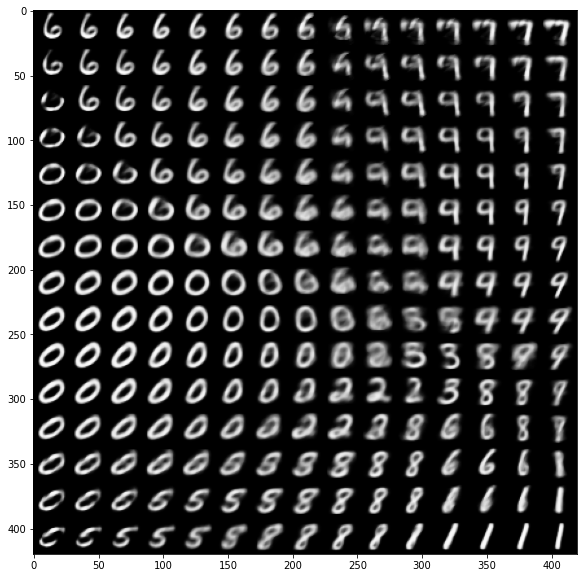

In [14]:
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = gen.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()